In [2]:
import pandas as pd
from dbgsom.dbgsom_ import DBGSOM
import seaborn.objects as so
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay


In [3]:
data = pd.read_csv(
    "F:\Dokumente\git\data\CIC-Darknet2020\Darknet.CSV",
    index_col="Flow ID",
    parse_dates=["Timestamp"],
).dropna()


In [4]:
data.replace(
    {
        -np.inf: 0,
        np.inf: 0,
        "AUDIO-STREAMING": "Audio-Streaming",
        "File-transfer": "File-Transfer",
        "Video-streaming": "Video-Streaming",
    },
    inplace=True,
)
data.Timestamp = data.Timestamp.astype("int64")
X = data.drop(columns=["Label", "Label.1"])
y_1 = data["Label"]
y_2 = data["Label.1"]

X_train, X_test, y_1_train, y_1_test, y_2_train, y_2_test = train_test_split(
    X, y_1, y_2, random_state=23, stratify=y_2
)


In [84]:
scaler = StandardScaler()
ohe = OneHotEncoder(max_categories=15, handle_unknown="infrequent_if_exist")
col_transformer = ColumnTransformer(
    transformers=[("ohe", ohe, ["Src IP", "Src Port", "Dst IP", "Dst Port"])],
    remainder="passthrough",
)
som = DBGSOM(
    max_epochs=300,
    spreading_factor=1,
    max_neurons=300,
    # metric="cosine",
    vertical_growth=True,
    # threshold_method="se",
    growth_criterion="entropy",
    min_samples_vertical_growth=200,
)

pipe = Pipeline(
    steps=[
        ("col_transformer", col_transformer),
        ("scaler", scaler),
        ("som", som),
    ]
)

# y_train = y_1_train
y_train = y_2_train


In [85]:
pipe.fit(X_train, y_train)


 51%|█████     | 152/300 [00:02<00:02, 61.36 epochs/s]


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=15),
                                                  ['Src IP', 'Src Port',
                                                   'Dst IP', 'Dst Port'])])),
                ('scaler', StandardScaler()),
                ('som',
                 DBGSOM(growth_criterion='entropy', max_epochs=300,
                        max_neurons=300, min_samples_vertical_growth=200,
                        spreading_factor=1, vertical_growth=True))])

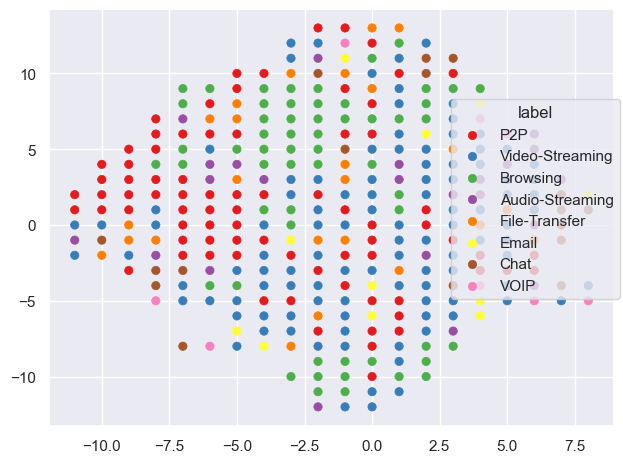

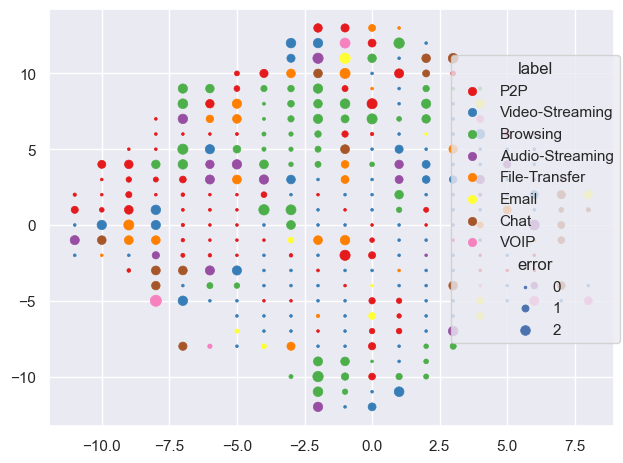

In [92]:
som.plot(
    color="label",
    palette="Set1",
    # pointsize="epoch_created",
)
som.plot(
    color="label",    
    palette="Set1",
    pointsize="error",
)


In [93]:
som.vertical_growing_threshold_

1.5

In [88]:
som.topographic_error_

0.058306317852834744

In [89]:
pipe.score(X_test, y_2_test)


0.8587826185293037

In [90]:
f1_score(
    y_2_test,
    pipe.predict(X_test),
    # average="macro",
    average=None,
)


array([0.82940622, 0.92725428, 0.67817147, 0.59881903, 0.69749009,
       0.97875464, 0.70849802, 0.68056338])

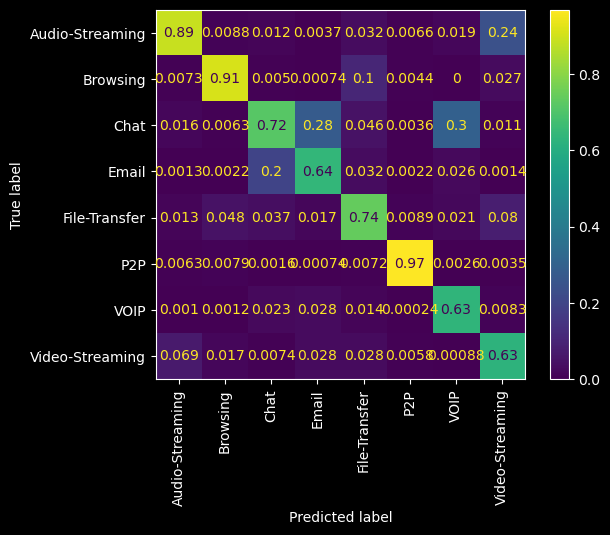

In [91]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_2_test,
    pipe.predict(X_test),
    normalize="pred",
    xticks_rotation="vertical",
)
